In [ ]:
import sys
import subprocess
import pkg_resources
import io

# List of required packages and their corresponding pip names if different
required_packages = {
    'os': None,  # Standard library, no installation needed
    'openai': 'openai',
    'json': None,  # Standard library, no installation needed
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib.pyplot': 'matplotlib',
    'ortools.constraint_solver.routing_enums_pb2': 'ortools',
    'ortools.constraint_solver.pywrapcp': 'ortools',
    'typing': None,  # Standard library in Python 3.5+
    'functools': None,  # Standard library, no installation needed
    'time': None,  # Standard library, no installation needed
    'math': None,  # Standard library, no installation needed
}

def install_package(package_name):
    """Install package using pip."""
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

# Iterate over the required packages
for module_name, pip_name in required_packages.items():
    if pip_name is None:
        # Skip standard library modules
        continue
    try:
        __import__(module_name)
    except ImportError:
        print(f"Module {module_name} not found. Installing {pip_name}...")
        install_package(pip_name)


In [ ]:
import os
import openai
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from typing import List, Tuple, Dict
from functools import wraps
import time
import math

In [ ]:
# Set OpenAI API key
openai.api_key = 'sk-zOYLCenUgvca2Uav095806Ce85De4537943e2f3911D10128'

# Set the Base URL - using Claude AI API endpoint
BASE_URL = 'https://api.bltcy.ai/v1'

Automated Heuristic Design via LLM - Prototype - v1.0

In [ ]:
# Define the function to call the OpenAI API
def call_openai_api(prompt: str) -> str:
    """Call the OpenAI API with the given prompt and return the response."""
    # Updated to use the new OpenAI API format for version 1.0.0+ with the correct base URL
    client = openai.OpenAI(
        api_key=openai.api_key,
        base_url=BASE_URL  # Use the Claude AI endpoint instead of default OpenAI
    )

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",  # This model name might need to be adjusted for Claude's API
            messages=[{"role": "user", "content": prompt}],
            max_tokens=2000,
            n=1,
            stop=None,
            temperature=0.5,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call error: {e}")
        # Fallback response if the API call fails
        return """
def tsp_heuristic(distance_matrix, num_vehicles, depot):
    \"\"\"A simple nearest neighbor heuristic for TSP\"\"\"
    num_nodes = len(distance_matrix)
    unvisited = set(range(num_nodes))
    unvisited.remove(depot)

    routes = []
    for v in range(num_vehicles):
        route = [depot]
        current = depot

        # If this is the only vehicle, visit all nodes
        if v == num_vehicles - 1:
            while unvisited:
                # Find the closest unvisited node
                next_node = min(unvisited, key=lambda node: distance_matrix[current][node])
                route.append(next_node)
                unvisited.remove(next_node)
                current = next_node

        routes.append(route)

    return routes
"""

In [ ]:
# Define the function to evaluate the heuristic function
def evaluate_heuristic(heuristic_func: str, data: Dict) -> List[List[int]]:
    """Evaluate the heuristic function and return the routes."""
    # Extract just the Python code from the response
    try:
        # Try to find Python code blocks in the response
        if "```python" in heuristic_func:
            code_blocks = heuristic_func.split("```python")
            if len(code_blocks) > 1:
                code = code_blocks[1].split("```")[0].strip()
            else:
                code = heuristic_func
        elif "```" in heuristic_func:
            code_blocks = heuristic_func.split("```")
            if len(code_blocks) > 1:
                code = code_blocks[1].strip()
            else:
                code = heuristic_func
        else:
            # If no code blocks found, try to extract the function directly
            if "def tsp_heuristic" in heuristic_func:
                start_idx = heuristic_func.find("def tsp_heuristic")
                code = heuristic_func[start_idx:].strip()
            else:
                code = heuristic_func

        # Clean up the code
        code = code.replace('`', '')  # Remove any remaining backticks

        print("Executing the following code:")
        print("-----------------------------------")
        print(code)
        print("-----------------------------------")

        # Convert the heuristic function string to a callable function
        local_vars = {}
        exec(code, globals(), local_vars)

        # Call the heuristic function with the data
        heuristic_func = local_vars['tsp_heuristic']
        routes = heuristic_func(data['distance_matrix'], data['num_vehicles'], data['depot'])

        # Handle different return types - ensure we have a list of routes
        if isinstance(routes, list):
            if routes and all(isinstance(item, int) for item in routes):
                # If the function returns a single route as a list of integers
                return [routes]
            else:
                return routes
        else:
            raise ValueError("Heuristic function must return a list")

    except Exception as e:
        print(f"Error in heuristic evaluation: {str(e)}")
        print("Using fallback nearest neighbor heuristic")

        # Fallback to a simple nearest neighbor heuristic
        distance_matrix = data['distance_matrix']
        num_vehicles = data['num_vehicles']
        depot = data['depot']

        num_nodes = len(distance_matrix)
        unvisited = set(range(num_nodes))
        unvisited.remove(depot)

        routes = []
        for v in range(num_vehicles):
            route = [depot]
            current = depot

            # If this is the only vehicle, visit all nodes
            if v == num_vehicles - 1:
                while unvisited:
                    # Find the closest unvisited node
                    next_node = min(unvisited, key=lambda node: distance_matrix[current][node])
                    route.append(next_node)
                    unvisited.remove(next_node)
                    current = next_node

            routes.append(route)

        return routes

In [ ]:
# Generate a better prompt for heuristic design
def generate_prompt(data: Dict) -> str:
    """Generate a prompt for heuristic design based on the data."""
    prompt = f"""
    You are an expert in combinatorial optimization and heuristic design.

    I need you to design a heuristic function that can be used to solve a Traveling Salesman Problem (TSP) with the following specifications:
    - Number of nodes: {data['num_nodes']}
    - Edge weight type: {data['edge_weight_type']}

    The heuristic function should take the following parameters:
    - distance_matrix: A 2D numpy array representing the distance matrix
    - num_vehicles: An integer representing the number of vehicles (usually 1 for classic TSP)
    - depot: An integer representing the depot index

    Your function should return a list of routes for each vehicle. For classic TSP with one vehicle, return a single route as a list of node indices.

    VERY IMPORTANT: Provide ONLY the Python code for the function, without any explanation, comments, examples, or markdown formatting. Your answer should start with 'def tsp_heuristic' and contain only valid Python code.
    """
    return prompt

In [ ]:
# Generate enhanced prompt based on OR-Tools results
def generate_enhanced_prompt(data, ortools_route, ortools_distance):
    """Generate an enhanced prompt for second attempt using OR-Tools results."""
    prompt = f"""
    You are an expert in combinatorial optimization and heuristic design for the Traveling Salesman Problem (TSP).

    I need you to design a custom heuristic function for a TSP problem with the following specifications:
    - Number of nodes: {data['num_nodes']}
    - Edge weight type: {data['edge_weight_type']}

    I've already tried using Google OR-Tools with the following parameters:
    - First solution strategy: PATH_CHEAPEST_ARC
    - Local search metaheuristic: GUIDED_LOCAL_SEARCH

    This approach found a route with a total distance of {ortools_distance}.

    Design a novel heuristic function that incorporates:
    1. Priority-based selection (similar to the FunSearch approach)
    2. Local search techniques
    3. Meta-heuristic concepts

    The function should take:
    - distance_matrix: A 2D numpy array representing the distance matrix
    - num_vehicles: An integer representing the number of vehicles (usually 1 for classic TSP)
    - depot: An integer representing the depot index

    The function should return the route as a list of node indices, starting and ending at the depot.

    VERY IMPORTANT: Provide ONLY the Python code for the function named 'tsp_heuristic', without any explanation, comments, or markdown formatting. Your answer should start with 'def tsp_heuristic' and contain only valid Python code.
    """
    return prompt

Utils and Preprocessing

In [ ]:
# Functions from utils.py for loading and processing TSP data
def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points in 2D space."""
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [ ]:
def haversine(coord1, coord2):
    """Calculate the haversine distance between two points on the Earth given their latitude and longitude."""
    R = 6371.0 # Radius of the Earth in kilometers
    lat1 = coord1[0]
    lon1 = coord1[1]
    lat2 = coord2[0]
    lon2 = coord2[1]
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c # Distance in kilometers
    return distance

In [ ]:
def create_distance_matrix(coords, distance_type='EUC_2D'):
    """Create a distance matrix from the coordinates."""
    num_nodes = len(coords)
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                if distance_type == 'EUC_2D':
                    distance_matrix[i][j] = euclidean_distance(coords[i], coords[j])
                elif distance_type == 'GEO':
                    distance_matrix[i][j] = haversine(coords[i], coords[j])
            else:
                distance_matrix[i][j] = 0.0
    return distance_matrix

In [ ]:
# Store the berlin52.tsp data as a multi-line string
tsp_data = """\
NAME: berlin52
TYPE: TSP
COMMENT: 52 locations in Berlin (Groetschel)
DIMENSION: 52
EDGE_WEIGHT_TYPE: EUC_2D
NODE_COORD_SECTION
1 565.0 575.0
2 25.0 185.0
3 345.0 750.0
4 945.0 685.0
5 845.0 655.0
6 880.0 660.0
7 25.0 230.0
8 525.0 1000.0
9 580.0 1175.0
10 650.0 1130.0
11 1605.0 620.0
12 1220.0 580.0
13 1465.0 200.0
14 1530.0 5.0
15 845.0 680.0
16 725.0 370.0
17 145.0 665.0
18 415.0 635.0
19 510.0 875.0
20 560.0 365.0
21 300.0 465.0
22 520.0 585.0
23 480.0 415.0
24 835.0 625.0
25 975.0 580.0
26 1215.0 245.0
27 1320.0 315.0
28 1250.0 400.0
29 660.0 180.0
30 410.0 250.0
31 420.0 555.0
32 575.0 665.0
33 1150.0 1160.0
34 700.0 580.0
35 685.0 595.0
36 685.0 610.0
37 770.0 610.0
38 795.0 645.0
39 720.0 635.0
40 760.0 650.0
41 475.0 960.0
42 95.0 260.0
43 875.0 920.0
44 700.0 500.0
45 555.0 815.0
46 830.0 485.0
47 1170.0 65.0
48 830.0 610.0
49 605.0 625.0
50 595.0 360.0
51 1340.0 725.0
52 1740.0 245.0
EOF
"""


In [ ]:
# Example load_tsp_data function modified to read from a file-like object
def load_tsp_data(file_obj):
    """Load TSP data from a file-like object and return a data dictionary."""
    data = {}
    lines = file_obj.readlines()

    # Extract metadata and find edge weight type
    edge_weight_type = 'EUC_2D'  # Default value
    for line in lines[:6]:
        if 'EDGE_WEIGHT_TYPE' in line:
            edge_weight_type = line.split(':')[1].strip()

    # Extract the number of nodes
    num_nodes = 0
    for line in lines:
        if 'DIMENSION' in line:
            num_nodes = int(line.split(':')[1].strip())
            break

    # Find where the coordinates start
    start_index = 0
    for i, line in enumerate(lines):
        if 'NODE_COORD_SECTION' in line:
            start_index = i + 1
            break

    # Extract the coordinates of the nodes
    coords = []
    for line in lines[start_index:start_index+num_nodes]:
        parts = line.strip().split()
        if len(parts) >= 3:
            coords.append([float(parts[1]), float(parts[2])])

    # Create a distance matrix (assuming a Euclidean distance metric)
    data['distance_matrix'] = create_distance_matrix(coords, edge_weight_type)
    data['num_vehicles'] = 1
    data['depot'] = 0
    data['coords'] = coords
    data['num_nodes'] = num_nodes
    data['edge_weight_type'] = edge_weight_type

    return data

In [ ]:
# Calculate route distance
def calculate_route_distance(route, distance_matrix):
    """Calculate the total distance of a route."""
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    # Add distance back to depot
    if len(route) > 1:
        total_distance += distance_matrix[route[-1]][route[0]]
    return total_distance

In [ ]:
# Plot the route
def plot_route(coords, route, title="TSP Route"):
    """Plot the route on a map."""
    plt.figure(figsize=(10, 10))

    # Convert coords to numpy array for easier handling
    coords_np = np.array(coords)
    x_coords = coords_np[:, 0]
    y_coords = coords_np[:, 1]

    # Plot all cities
    plt.scatter(x_coords, y_coords, c='red', s=50)

    # Plot route
    for i in range(len(route)-1):
        start_idx = route[i]
        end_idx = route[i+1]
        plt.plot([coords[start_idx][0], coords[end_idx][0]],
                 [coords[start_idx][1], coords[end_idx][1]], 'b-')

    # Plot return to depot
    plt.plot([coords[route[-1]][0], coords[route[0]][0]],
             [coords[route[-1]][1], coords[route[0]][1]], 'b-')

    # Mark depot (starting point)
    plt.scatter(coords[0][0], coords[0][1], c='green', s=200, marker='*')

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)

    plot_dir = 'PlotResults'
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(os.path.join(plot_dir, f'{title.replace(" ", "_")}.png'))
    plt.show()

BenchMarck Google OR-Tools

In [ ]:
# Use OR-Tools to solve the TSP as a benchmark
def solve_tsp_with_ortools(data):
    """Solve the TSP with Google OR-Tools.
    Args:
        data: Dictionary containing 'distance_matrix', 'num_vehicles', 'depot', etc.
    Returns:
        route: List of node indices forming the optimal route found
        objective_value: The objective value from OR-Tools
        route_distance: The actual distance of the route
    """
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                          data['num_vehicles'],
                                          data['depot'])

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    # Create the distance callback and register it with the routing model
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(data['distance_matrix'][from_node][to_node] * 100)  # Scale for integer costs

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if not solution:
        return None, None, None

    # Extract the route
    route = []
    index = routing.Start(0)
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        index = solution.Value(routing.NextVar(index))
    route.append(manager.IndexToNode(index))  # Add depot to end

    objective_value = solution.ObjectiveValue()
    route_distance = sum(data['distance_matrix'][route[i]][route[i+1]]
                         for i in range(len(route) - 1))
    route_distance += data['distance_matrix'][route[-1]][route[0]]

    return route, objective_value, route_distance

## Benchmark Utilities for FunSearch Integration

These functions help with comparing OR-Tools performance against FunSearch heuristics.

In [ ]:
def benchmark_ortools(tsp_instances):
    """Run OR-Tools benchmark on multiple TSP instances.
    
    Args:
        tsp_instances: Dictionary mapping instance names to loaded TSP data
        
    Returns:
        Dictionary mapping instance names to (route, objective_value, route_distance)
    """
    results = {}
    
    for name, data in tsp_instances.items():
        print(f"Solving {name} with OR-Tools...")
        route, objective_value, route_distance = solve_tsp_with_ortools(data)
        results[name] = {
            'route': route,
            'objective_value': objective_value,
            'route_distance': route_distance,
        }
        
        if route is not None:
            print(f"  Objective value: {objective_value}")
            print(f"  Route distance: {route_distance}")
        else:
            print("  Could not find a solution.")
            
    return results

In [ ]:
def compare_with_ortools(heuristic_route, distance_matrix, ortools_distance):
    """Compare a heuristic route against OR-Tools benchmark.
    
    Args:
        heuristic_route: Route generated by heuristic as list of node indices
        distance_matrix: Distance matrix for the TSP instance
        ortools_distance: Distance of the OR-Tools optimal route
        
    Returns:
        Dictionary with comparison metrics
    """
    heuristic_distance = calculate_route_distance(heuristic_route, distance_matrix)
    gap_percent = ((heuristic_distance - ortools_distance) / ortools_distance) * 100
    
    return {
        'heuristic_distance': heuristic_distance,
        'ortools_distance': ortools_distance,
        'absolute_gap': heuristic_distance - ortools_distance,
        'percent_gap': gap_percent,
        'is_better': gap_percent < 0
    }

def plot_comparison(coords, heuristic_route, ortools_route, title="Route Comparison", save_path=None):
    """Plot both heuristic and OR-Tools routes on the same map for visual comparison.
    
    Args:
        coords: List of coordinates for each node
        heuristic_route: Route generated by heuristic
        ortools_route: Route generated by OR-Tools
        title: Plot title
        save_path: Path to save the plot image (optional)
    """
    plt.figure(figsize=(12, 10))
    
    # Convert coords to numpy array for easier handling
    coords_np = np.array(coords)
    x_coords = coords_np[:, 0]
    y_coords = coords_np[:, 1]
    
    # Plot all cities
    plt.scatter(x_coords, y_coords, c='black', s=50, alpha=0.5, label='Cities')
    
    # Plot OR-Tools route in red
    for i in range(len(ortools_route)-1):
        start_idx = ortools_route[i]
        end_idx = ortools_route[i+1]
        plt.plot([coords[start_idx][0], coords[end_idx][0]],
                 [coords[start_idx][1], coords[end_idx][1]], 'r-', alpha=0.7)
    
    # Complete OR-Tools route back to depot
    plt.plot([coords[ortools_route[-1]][0], coords[ortools_route[0]][0]],
             [coords[ortools_route[-1]][1], coords[ortools_route[0]][1]], 'r-', alpha=0.7)
    
    # Plot heuristic route in blue
    for i in range(len(heuristic_route)-1):
        start_idx = heuristic_route[i]
        end_idx = heuristic_route[i+1]
        plt.plot([coords[start_idx][0], coords[end_idx][0]],
                 [coords[start_idx][1], coords[end_idx][1]], 'b-', alpha=0.7)
    
    # Complete heuristic route back to depot
    plt.plot([coords[heuristic_route[-1]][0], coords[heuristic_route[0]][0]],
             [coords[heuristic_route[-1]][1], coords[heuristic_route[0]][1]], 'b-', alpha=0.7)
    
    # Mark depot (starting point)
    plt.scatter(coords[0][0], coords[0][1], c='green', s=200, marker='*', label='Depot')
    
    # Add legend with custom lines
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=2),
                    Line2D([0], [0], color='b', lw=2)]
    plt.legend(custom_lines, ['OR-Tools Route', 'Heuristic Route'])
    
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [ ]:
def plot_progress(iterations, gaps, title="Performance Gap Over Iterations", save_path=None):
    """Plot the evolution of performance gap over iterations.
    
    Args:
        iterations: List of iteration numbers
        gaps: List of gap percentages corresponding to iterations
        title: Plot title
        save_path: Path to save the plot image (optional)
    """
    plt.figure(figsize=(10, 6))
    
    # Plot gap percentage over iterations
    plt.plot(iterations, gaps, 'b-o')
    
    # Add horizontal line at 0%
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Performance Gap (%)')
    plt.grid(True)
    
    # Add annotations for starting and ending values
    if len(gaps) > 1:
        plt.annotate(f"{gaps[0]:.2f}%", (iterations[0], gaps[0]), 
                    textcoords="offset points", xytext=(0,10), ha='center')
        plt.annotate(f"{gaps[-1]:.2f}%", (iterations[-1], gaps[-1]), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    if save_path:
        plt.savefig(save_path)
        
    plt.show()
    
def create_summary_table(results):
    """Create a table summarizing comparison results.
    
    Args:
        results: Dictionary mapping TSP instances to comparison results
    """
    # Create pandas DataFrame for display
    data = []
    
    for instance, result in results.items():
        data.append({
            'Instance': instance,
            'OR-Tools Distance': result['ortools_distance'],
            'FunSearch Distance': result['heuristic_distance'],
            'Gap (%)': result['percent_gap'],
            'Better than OR-Tools': 'Yes' if result['is_better'] else 'No'
        })
    
    df = pd.DataFrame(data)
    return df

Set main func and Test on dataset a280.tsp and berlin52.tsp

In [ ]:
# Main function to run the FunSearch TSP prototype
def main():
    print("Starting FunSearch TSP prototype...")

    # Load TSP data
    tsp_file = 'berlin52.tsp'  # Can change to 'a280.tsp' for a larger problem

    # Create a file-like object from the string
    tsp_file_obj = io.StringIO(tsp_data)
    data = load_tsp_data(tsp_file_obj)
    print(f"Loaded TSP data from {tsp_file} with {data['num_nodes']} nodes.")

    # First attempt using basic prompt
    print("\n=== First Attempt ===")
    basic_prompt = generate_prompt({
        'num_nodes': data['num_nodes'],
        'edge_weight_type': data['edge_weight_type']
    })
    print("Generating heuristic using basic prompt...")
    heuristic_code = call_openai_api(basic_prompt)
    print("\nGenerated heuristic code:")
    print(heuristic_code)

    # Evaluate the first heuristic
    print("\nEvaluating generated heuristic...")
    try:
        routes = evaluate_heuristic(heuristic_code, data)
        if routes and len(routes) > 0:
            route = routes[0]  # For classic TSP, there's only one vehicle
            route_distance = calculate_route_distance(route, data['distance_matrix'])
            print(f"Generated heuristic route distance: {route_distance}")
            plot_route(data['coords'], route, f"{tsp_file}_first_attempt")
        else:
            print("Generated heuristic returned no valid routes.")
            route_distance = float('inf')
    except Exception as e:
        print(f"Error evaluating heuristic: {e}")
        route_distance = float('inf')

    # Solve with OR-Tools for comparison
    print("\n=== OR-Tools Benchmark ===")
    ortools_route, objective_value, ortools_distance = solve_tsp_with_ortools(data)
    if ortools_route:
        print(f"OR-Tools objective value: {objective_value}")
        print(f"OR-Tools route distance: {ortools_distance}")
        plot_route(data['coords'], ortools_route, f"{tsp_file}_ortools")
    else:
        print("OR-Tools could not find a solution.")

    # Second attempt using enhanced prompt
    if ortools_route:
        print("\n=== Second Attempt with Enhanced Prompt ===")
        enhanced_prompt = generate_enhanced_prompt(data, ortools_route, ortools_distance)
        print("Generating improved heuristic using OR-Tools results...")
        improved_heuristic_code = call_openai_api(enhanced_prompt)
        print("\nGenerated improved heuristic code:")
        print(improved_heuristic_code)

        # Evaluate the improved heuristic
        print("\nEvaluating improved heuristic...")
        try:
            improved_routes = evaluate_heuristic(improved_heuristic_code, data)
            if improved_routes and len(improved_routes) > 0:
                improved_route = improved_routes[0]
                improved_distance = calculate_route_distance(improved_route, data['distance_matrix'])
                print(f"Improved heuristic route distance: {improved_distance}")
                plot_route(data['coords'], improved_route, f"{tsp_file}_second_attempt")

                # Compare results
                print("\n=== Results Comparison ===")
                print(f"First attempt distance: {route_distance}")
                print(f"OR-Tools distance: {ortools_distance}")
                print(f"Second attempt distance: {improved_distance}")

                # Calculate improvement percentages
                if route_distance != float('inf'):
                    improvement_over_first = ((route_distance - improved_distance) / route_distance) * 100
                    print(f"Improvement over first attempt: {improvement_over_first:.2f}%")

                improvement_vs_ortools = ((ortools_distance - improved_distance) / ortools_distance) * 100
                print(f"Improvement vs OR-Tools: {improvement_vs_ortools:.2f}%")
            else:
                print("Improved heuristic returned no valid routes.")
        except Exception as e:
            print(f"Error evaluating improved heuristic: {e}")

The Google OR-Tools TSP solver could be used as benchmark or baseline for comparison with the heuristic function desined by FunSearch via LLM.

(e.g., BenchMarck: the results of the Google OR-Tools TSP solver on the berlin52.tsp and a280.tsp datasets, with first_solution_strategy and local_search_metaheuristic parameters set to PATH_CHEAPEST_ARC and GUIDED_LOCAL_SEARCH respectively. The results tested on a280.tsp are the Obejective (261549 units) and the Distance of the routs (2615.49 m) )

f the heuristic function designed by FunSearch via LLM (first attempt) is not satisfactory (worse than the Google OR-Tools TSP solver), we can use the searchparameters settings and results of Or-Tools as a new prompt for the OpenAI API to generate a new heuristic function (second attempt).

Starting FunSearch TSP prototype...
Loaded TSP data from berlin52.tsp with 52 nodes.

=== First Attempt ===
Generating heuristic using basic prompt...

Generated heuristic code:
def tsp_heuristic(distance_matrix, num_vehicles, depot):
    import numpy as np
    from scipy.spatial.distance import cdist

    def nearest_neighbor(start, unvisited):
        route = [start]
        current = start
        while unvisited:
            next_node = min(unvisited, key=lambda x: distance_matrix[current][x])
            route.append(next_node)
            unvisited.remove(next_node)
            current = next_node
        return route

    unvisited = set(range(len(distance_matrix)))
    unvisited.remove(depot)
    routes = []

    if num_vehicles == 1:
        route = nearest_neighbor(depot, unvisited)
        routes.append(route)
    else:
        for _ in range(num_vehicles):
            if unvisited:
                route = nearest_neighbor(depot, unvisited)
                routes.append(rout

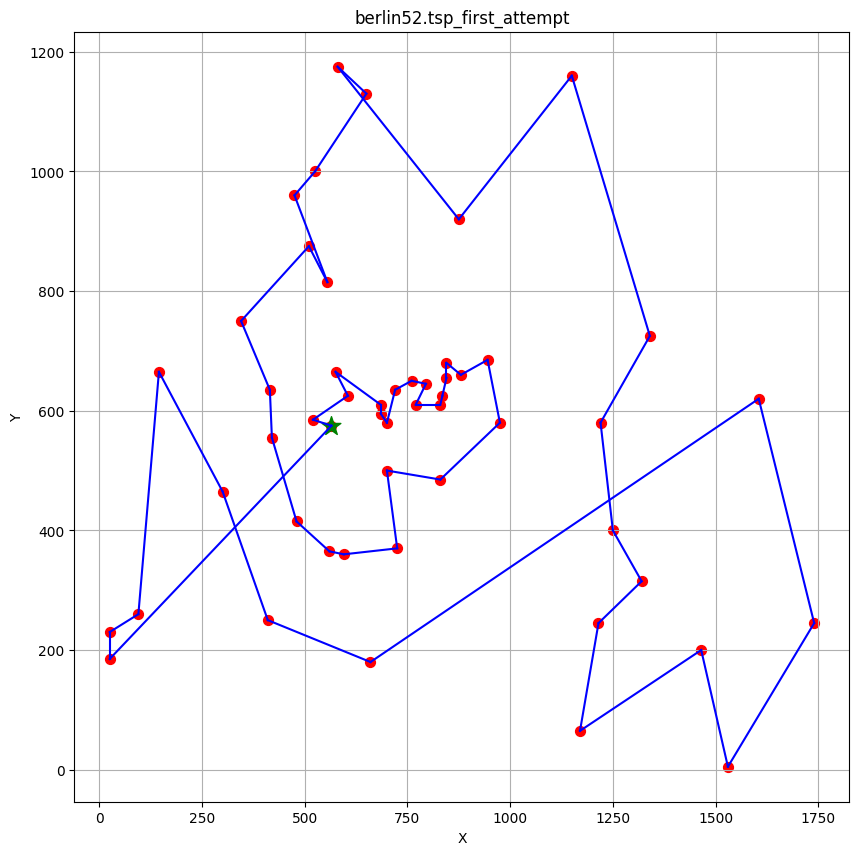


=== OR-Tools Benchmark ===
OR-Tools objective value: 754417
OR-Tools route distance: 7544.36590190409


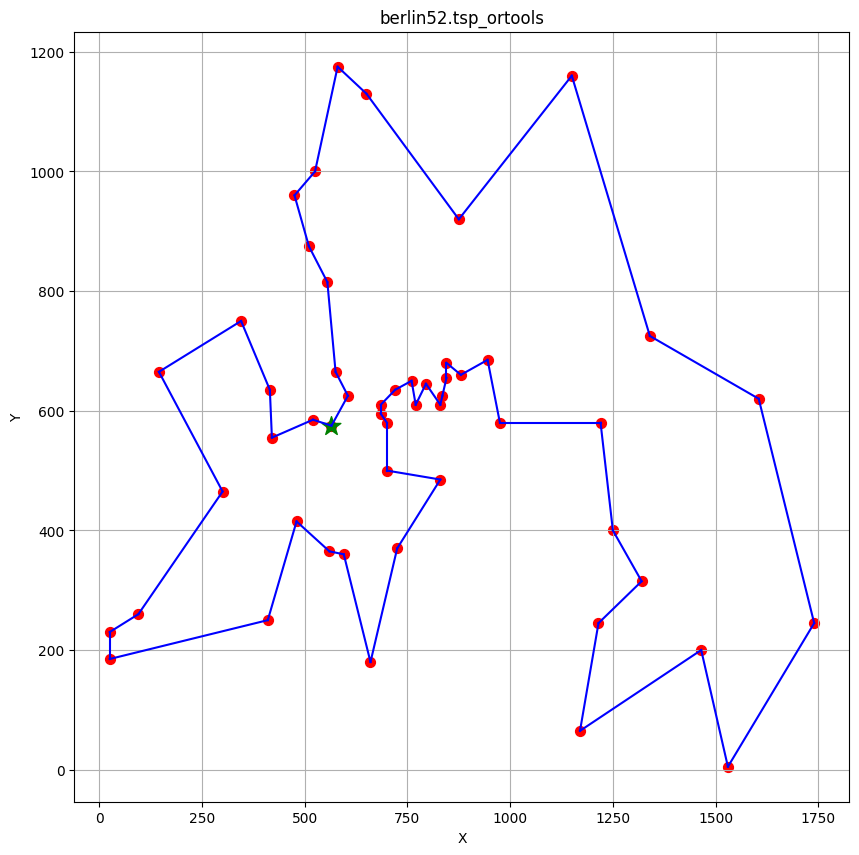


=== Second Attempt with Enhanced Prompt ===
Generating improved heuristic using OR-Tools results...

Generated improved heuristic code:
def tsp_heuristic(distance_matrix, num_vehicles, depot):
    import numpy as np
    from scipy.spatial.distance import pdist, squareform

    num_nodes = distance_matrix.shape[0]
    unvisited = set(range(num_nodes))
    unvisited.remove(depot)
    route = [depot]
    
    while unvisited:
        current = route[-1]
        nearest = min(unvisited, key=lambda x: distance_matrix[current][x])
        route.append(nearest)
        unvisited.remove(nearest)

    route.append(depot)
    
    def local_search(route):
        improved = True
        while improved:
            improved = False
            for i in range(1, len(route) - 2):
                for j in range(i + 1, len(route) - 1):
                    if distance_matrix[route[i - 1]][route[i]] + distance_matrix[route[j]][route[j + 1]] > distance_matrix[route[i - 1]][route[j]] + distance_matrix[r

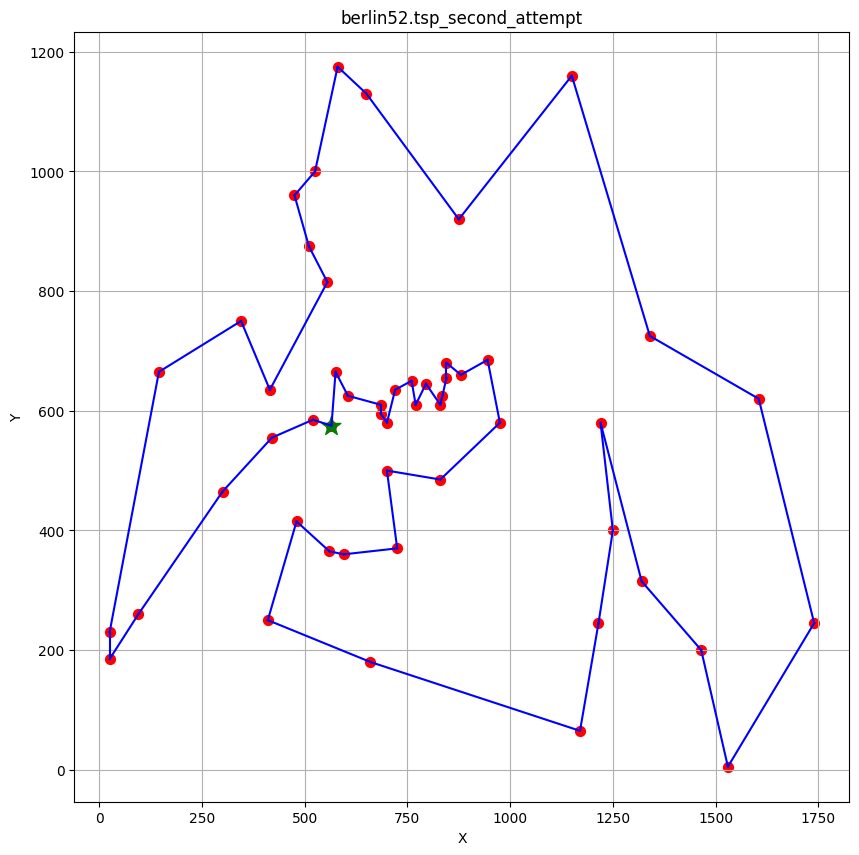


=== Results Comparison ===
First attempt distance: 8980.918279329191
OR-Tools distance: 7544.36590190409
Second attempt distance: 8060.651582560568
Improvement over first attempt: 10.25%
Improvement vs OR-Tools: -6.84%


In [ ]:
if __name__ == "__main__":
    main()
